## Javier Mombiela
## Carnet: 20067
## 12 de abril 2024

### Proyecto 2: “Entrenamiento Incremental en Modelos de Deep Learning y Machine Learning

Importando librerias

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.regularizers import l2
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, accuracy_score, precision_score

### Analasis Exploratorio

El dataset contiene información detallada sobre transacciones de tarjetas de crédito, recopilada para la identificación de fraudes. Incluye datos sobre la fecha, el monto y la ubicación de las transacciones, así como información demográfica de los titulares de las tarjetas y características de las transacciones que permiten distinguir entre actividades legítimas y fraudulentas.

In [63]:
df = pd.read_csv('fraud_feature_engineering_example.csv')

df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,amt_month,amt_year,amt_month_shopping_net_spend,count_month_shopping_net,first_time_at_merchant
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,4.97,4.97,0.0,0.0,True
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,107.23,107.23,0.0,0.0,True
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,220.11,220.11,0.0,0.0,True
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,45.00,45.00,0.0,0.0,True
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,41.96,41.96,0.0,0.0,True


In [64]:
# Información general sobre el dataframe
print("\nInformación del dataframe:")
print(df.info())


Información del dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 27 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   trans_date_trans_time         object 
 1   cc_num                        int64  
 2   merchant                      object 
 3   category                      object 
 4   amt                           float64
 5   first                         object 
 6   last                          object 
 7   gender                        object 
 8   street                        object 
 9   city                          object 
 10  state                         object 
 11  zip                           int64  
 12  lat                           float64
 13  long                          float64
 14  city_pop                      int64  
 15  job                           object 
 16  dob                           object 
 17  trans_num                     object 

Al revisar la información del dataset utilizando df.info(), se observa que varias columnas están codificadas como tipo object. Estas columnas incluyen nombres, direcciones y otros datos no numéricos que deberán ser transformados a un formato numérico o categórico para su procesamiento en modelos de machine learning. Se deberá realizar una adecuada codificación de estas características antes de entrenar cualquier modelo predictivo.

In [65]:
# Verificar valores faltantes en el conjunto de datos
missing_values = df.isnull().sum()
print("Valores faltantes por columna:")
print(missing_values)

Valores faltantes por columna:
trans_date_trans_time           0
cc_num                          0
merchant                        0
category                        0
amt                             0
first                           0
last                            0
gender                          0
street                          0
city                            0
state                           0
zip                             0
lat                             0
long                            0
city_pop                        0
job                             0
dob                             0
trans_num                       0
unix_time                       0
merch_lat                       0
merch_long                      0
is_fraud                        0
amt_month                       0
amt_year                        0
amt_month_shopping_net_spend    0
count_month_shopping_net        0
first_time_at_merchant          0
dtype: int64


In [66]:
# Estadísticas descriptivas
print("\nEstadísticas descriptivas del dataset:")
df.describe()


Estadísticas descriptivas del dataset:


,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,amt_month,amt_year,amt_month_shopping_net_spend,count_month_shopping_net
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03,4.153689e+03,4.530560e+04,3.762028e+02,4.567241e+00
std,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02,3.909005e+03,3.586752e+04,7.253531e+02,4.575502e+00
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00,1.000000e+00,1.020000e+00,0.000000e+00,0.000000e+00
25%,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00,1.344790e+03,1.734142e+04,9.020000e+00,1.000000e+00
50%,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00,3.071990e+03,3.743910e+04,7.589000e+01,3.000000e+00
75%,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00,5.738470e+03,6.472088e+04,4.259800e+02,7.000000e+00
max,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00,4.326189e+04,2.190868e+05,1.204718e+04,4.800000e+01


In [67]:
# Distribución de clases
class_distribution = df['is_fraud'].value_counts()
print("\nDistribución de clases:")
print(class_distribution)


Distribución de clases:
is_fraud
0    1842743
1       9651
Name: count, dtype: int64


El conjunto de datos presenta una distribución altamente desbalanceada en la variable objetivo is_fraud. La mayoría de las transacciones están etiquetadas como no fraudulentas (clase 0), con un total de 1,842,743 instancias, mientras que solo hay 9,651 transacciones etiquetadas como fraudulentas (clase 1). Esta disparidad en el número de instancias entre las clases podría afectar el rendimiento de los modelos predictivos, lo que requerirá estrategias adecuadas de manejo de desbalance de clases durante el entrenamiento del modelo.

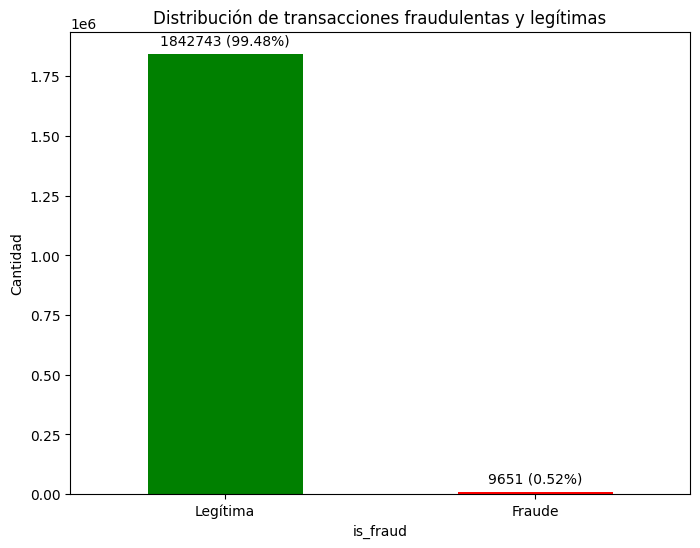

In [68]:
# Calcular la cantidad de transacciones fraudulentas y legítimas
fraud_counts = df['is_fraud'].value_counts()
total_transactions = fraud_counts.sum()

# Visualizar la distribución de la variable objetivo 'is_fraud'
plt.figure(figsize=(8, 6))
fraud_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Distribución de transacciones fraudulentas y legítimas')
plt.xlabel('is_fraud')
plt.ylabel('Cantidad')
plt.xticks([0, 1], ['Legítima', 'Fraude'], rotation=0)

# Mostrar la proporción en el gráfico
for i, count in enumerate(fraud_counts):
    plt.text(i, count + total_transactions * 0.02, f"{count} ({count / total_transactions:.2%})", ha='center')

plt.show()

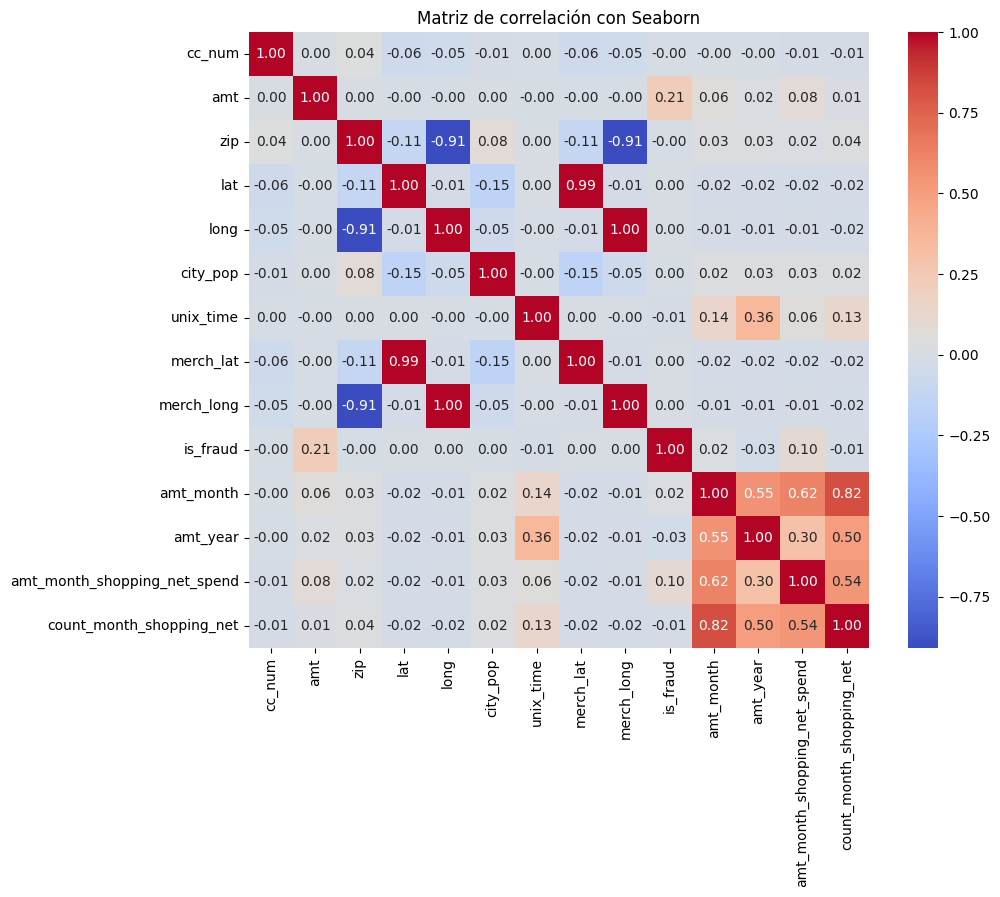

In [69]:
# Matriz de correlación
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación con Seaborn')
plt.show()

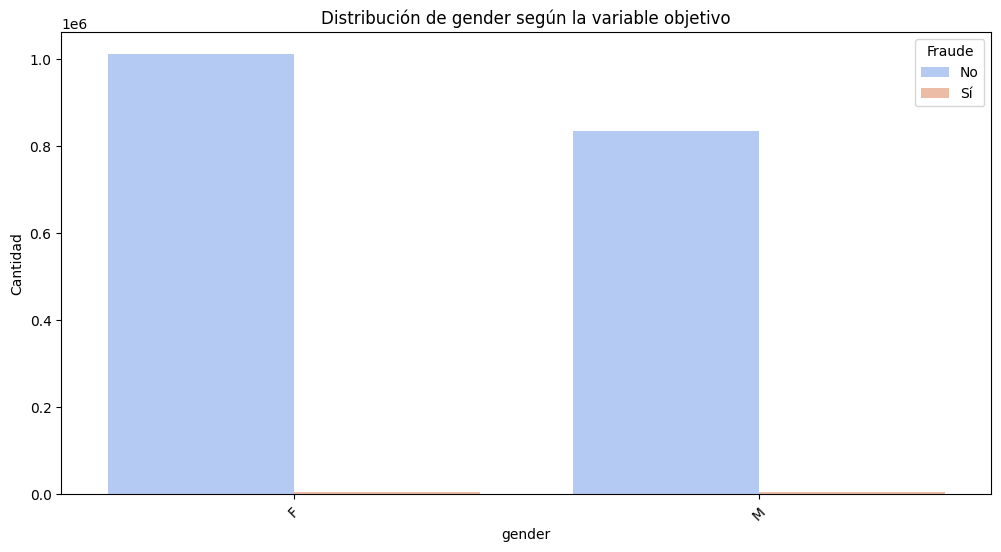

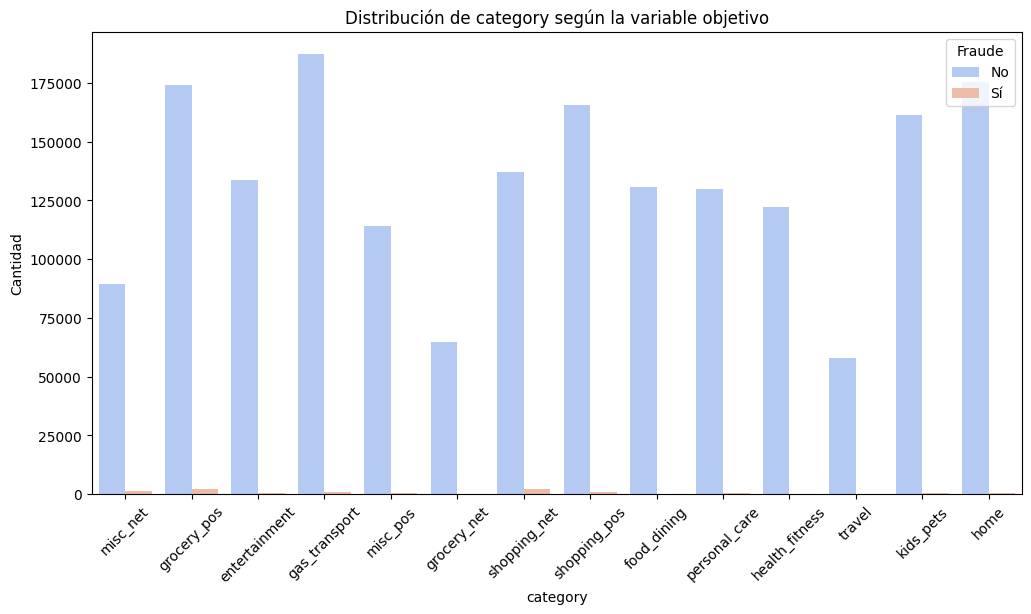

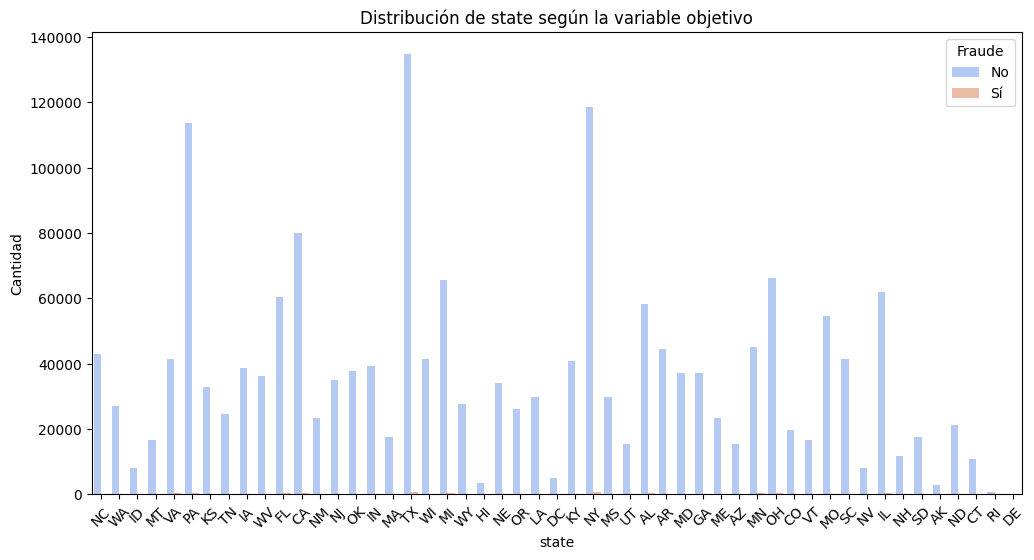

In [70]:
# Gráficos de barras para variables categóricas
categorical_variables = ['gender', 'category', 'state']  # Lista de variables categóricas que deseas explorar

for column in categorical_variables:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=column, hue='is_fraud', palette='coolwarm')
    plt.title(f'Distribución de {column} según la variable objetivo')
    plt.xlabel(column)
    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)
    plt.legend(title='Fraude', loc='upper right', labels=['No', 'Sí'])
    plt.show()

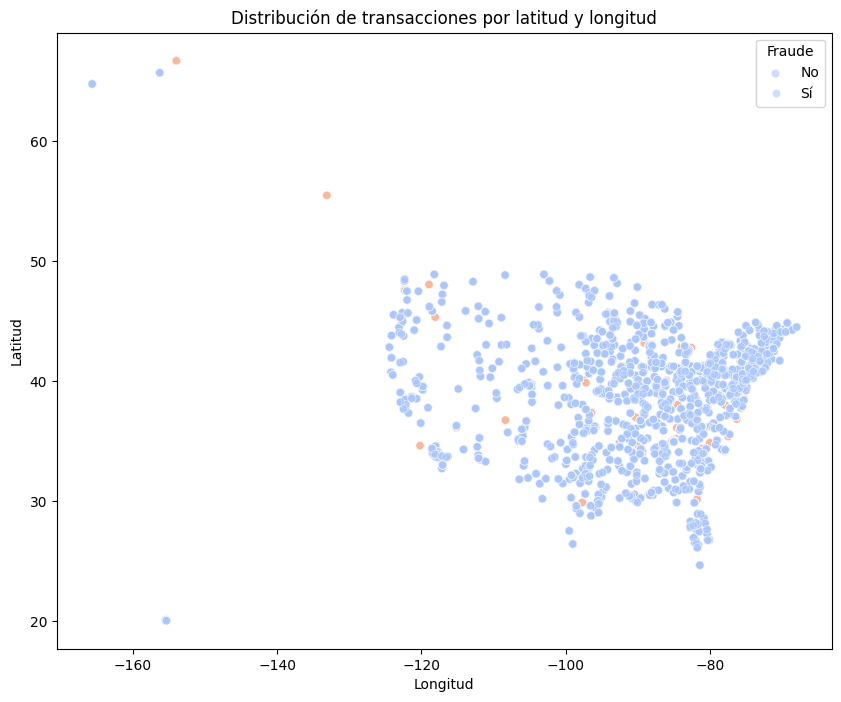

In [71]:
# Gráfico de densidad de dispersión
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='long', y='lat', hue='is_fraud', palette='coolwarm', alpha=0.6)
plt.title('Distribución de transacciones por latitud y longitud')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Fraude', loc='upper right', labels=['No', 'Sí'])
plt.show()

#### Feature Engineering

Agregando caracteristicas de la fecha

In [72]:
# Convertir la columna 'trans_date_trans_time' a formato de fecha y hora
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Agregar características temporales
df['hour_of_day'] = df['trans_date_trans_time'].dt.hour
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek  # Lunes=0, Domingo=6
df['month'] = df['trans_date_trans_time'].dt.month
df['year'] = df['trans_date_trans_time'].dt.year

# Mostrar las primeras filas del conjunto de datos para verificar las nuevas características
df[['trans_date_trans_time', 'hour_of_day', 'day_of_week', 'month', 'year']].head()

,trans_date_trans_time,hour_of_day,day_of_week,month,year
0,2019-01-01 00:00:18,0,1,1,2019
1,2019-01-01 00:00:44,0,1,1,2019
2,2019-01-01 00:00:51,0,1,1,2019
3,2019-01-01 00:01:16,0,1,1,2019
4,2019-01-01 00:03:06,0,1,1,2019


Agregando caracteristicas de monto

In [73]:
# Calcular el monto promedio de transacción por cliente
avg_transaction_amt_by_customer = df.groupby('cc_num')['amt'].mean()
df['avg_transaction_amt'] = df['cc_num'].map(avg_transaction_amt_by_customer)

# Calcular la frecuencia de transacciones por cliente
transaction_count_by_customer = df['cc_num'].value_counts()
df['transaction_count'] = df['cc_num'].map(transaction_count_by_customer)

# Calcular la desviación estándar del monto de transacción por cliente
std_transaction_amt_by_customer = df.groupby('cc_num')['amt'].std()
df['std_transaction_amt'] = df['cc_num'].map(std_transaction_amt_by_customer)

# Mostrar las primeras filas del conjunto de datos para verificar las nuevas características
df[['amt', 'cc_num', 'avg_transaction_amt', 'std_transaction_amt', 'transaction_count']].head()

,amt,cc_num,avg_transaction_amt,std_transaction_amt,transaction_count
0,4.97,2703186189652095,89.408743,127.530101,2927
1,107.23,630423337322,56.078113,159.201852,4362
2,220.11,38859492057661,69.924272,116.688602,735
3,45.00,3534093764340240,80.090040,280.077880,743
4,41.96,375534208663984,95.341146,94.322842,2922


In [74]:
# Crear una nueva columna para almacenar la diversidad de comercios visitados por cada tarjetahabiente en todo el conjunto de datos
df['unique_merchants_visited'] = df.groupby('cc_num')['merchant'].transform('nunique')

# Mostrar las primeras filas del conjunto de datos para verificar las nuevas características
df[['cc_num', 'merchant', 'unique_merchants_visited']].head()

,cc_num,merchant,unique_merchants_visited
0,2703186189652095,"fraud_Rippin, Kub and Mann",660
1,630423337322,"fraud_Heller, Gutmann and Zieme",681
2,38859492057661,fraud_Lind-Buckridge,431
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",423
4,375534208663984,fraud_Keeling-Crist,652


Agregando caracteristicas de localizacion

In [75]:
# Calcular la diferencia entre la latitud y la longitud del cliente y del vendedor
df['customer_merchant_distance'] = np.sqrt((df['lat'] - df['merch_lat'])**2 + (df['long'] - df['merch_long'])**2)

# Mostrar las primeras filas del conjunto de datos para verificar la nueva característica
df[['lat', 'long', 'merch_lat', 'merch_long', 'customer_merchant_distance']].head()

,lat,long,merch_lat,merch_long,customer_merchant_distance
0,36.0788,-81.1781,36.011293,-82.048315,0.872830
1,48.8878,-118.2105,49.159047,-118.186462,0.272310
2,42.1808,-112.2620,43.150704,-112.154481,0.975845
3,46.2306,-112.1138,47.034331,-112.561071,0.919802
4,38.4207,-79.4629,38.674999,-78.632459,0.868505


Aplicando Label Encoder a las variables categoricas

In [76]:
# Inicializar LabelEncoder
label_encoder = LabelEncoder()

# Codificar variables categóricas
df['state'] = label_encoder.fit_transform(df['state'])
df['gender'] = label_encoder.fit_transform(df['gender'])
df['category'] = label_encoder.fit_transform(df['category'])
df['first_time_at_merchant'] = label_encoder.fit_transform(df['first_time_at_merchant'])

Eliminando columnas innecesarias

In [77]:
# Variables a eliminar
variables_a_eliminar = ['trans_date_trans_time','trans_num', 'first', 'last', 'street', 'city', 'merchant', 'lat', 'long', 'city_pop', 'dob', 'unix_time', 'merch_lat', 'merch_long', 'job']

# Eliminar las variables del conjunto de datos
df = df.drop(variables_a_eliminar, axis=1)

# Mostrar las primeras filas del conjunto de datos para verificar los cambios
df.head()

,cc_num,category,amt,gender,state,zip,is_fraud,amt_month,amt_year,amt_month_shopping_net_spend,...,first_time_at_merchant,hour_of_day,day_of_week,month,year,avg_transaction_amt,transaction_count,std_transaction_amt,unique_merchants_visited,customer_merchant_distance
0,2703186189652095,8,4.97,0,27,28654,0,4.97,4.97,0.0,...,1,0,1,1,2019,89.408743,2927,127.530101,660,0.872830
1,630423337322,4,107.23,0,47,99160,0,107.23,107.23,0.0,...,1,0,1,1,2019,56.078113,4362,159.201852,681,0.272310
2,38859492057661,0,220.11,1,13,83252,0,220.11,220.11,0.0,...,1,0,1,1,2019,69.924272,735,116.688602,431,0.975845
3,3534093764340240,2,45.00,1,26,59632,0,45.00,45.00,0.0,...,1,0,1,1,2019,80.090040,743,280.077880,423,0.919802
4,375534208663984,9,41.96,1,45,24433,0,41.96,41.96,0.0,...,1,0,1,1,2019,95.341146,2922,94.322842,652,0.868505


Guardando el nuevo dataset

In [78]:
# guardar el dataframe modificado
df.to_csv('processed.csv', index=False)

df.head()

,cc_num,category,amt,gender,state,zip,is_fraud,amt_month,amt_year,amt_month_shopping_net_spend,...,first_time_at_merchant,hour_of_day,day_of_week,month,year,avg_transaction_amt,transaction_count,std_transaction_amt,unique_merchants_visited,customer_merchant_distance
0,2703186189652095,8,4.97,0,27,28654,0,4.97,4.97,0.0,...,1,0,1,1,2019,89.408743,2927,127.530101,660,0.872830
1,630423337322,4,107.23,0,47,99160,0,107.23,107.23,0.0,...,1,0,1,1,2019,56.078113,4362,159.201852,681,0.272310
2,38859492057661,0,220.11,1,13,83252,0,220.11,220.11,0.0,...,1,0,1,1,2019,69.924272,735,116.688602,431,0.975845
3,3534093764340240,2,45.00,1,26,59632,0,45.00,45.00,0.0,...,1,0,1,1,2019,80.090040,743,280.077880,423,0.919802
4,375534208663984,9,41.96,1,45,24433,0,41.96,41.96,0.0,...,1,0,1,1,2019,95.341146,2922,94.322842,652,0.868505


### SMOTE y Division de Datos

In [79]:
df_processed = pd.read_csv('processed.csv')

print(df_processed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 21 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   cc_num                        int64  
 1   category                      int64  
 2   amt                           float64
 3   gender                        int64  
 4   state                         int64  
 5   zip                           int64  
 6   is_fraud                      int64  
 7   amt_month                     float64
 8   amt_year                      float64
 9   amt_month_shopping_net_spend  float64
 10  count_month_shopping_net      float64
 11  first_time_at_merchant        int64  
 12  hour_of_day                   int64  
 13  day_of_week                   int64  
 14  month                         int64  
 15  year                          int64  
 16  avg_transaction_amt           float64
 17  transaction_count             int64  
 18  std_transaction_amt   

### Entrenamiento Inicial - 2019

Para el entrenamiento incremental, se seleccionó todo el año 2019 como el conjunto de datos inicial. Esto se debe a que el año 2019 representa el conjunto de datos más antiguo y completo disponible al momento de iniciar el proceso de entrenamiento. Al tomar todo el año 2019 como punto de partida, el modelo tiene la oportunidad de aprender de la totalidad de los datos históricos disponibles antes de comenzar a actualizar y adaptarse a nuevos datos.

In [80]:
# Seleccionar solo los datos del año 2019
df_subset_2019 = df_processed[df_processed['year'] == 2019]

X = df_subset_2019.drop(columns=['is_fraud'])
y = df_subset_2019['is_fraud']

# Imputar valores faltantes en las características numéricas
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Escalar las características numéricas para un mejor desempeño de SMOTE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [81]:
# Dividir los datos en Train, Dev y Test
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42)

# Dividir los datos de Train y Dev
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.176, random_state=42)

# Calcular la cantidad de transacciones legítimas y fraudulentas en el conjunto de entrenamiento
non_fraud_count = len(y_train[y_train == 0])
fraud_count = non_fraud_count // 5

# Definir la estrategia de muestreo para SMOTE
sampling_strategy = {0: non_fraud_count, 1: fraud_count}
print("Estrategia de muestreo para SMOTE:", sampling_strategy)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verificar la forma de los datos después de aplicar SMOTE
print("Forma de X_train_resampled después de SMOTE:", X_train_resampled.shape)
print("Forma de y_train_resampled después de SMOTE:", y_train_resampled.shape)

Estrategia de muestreo para SMOTE: {0: 644087, 1: 128817}
Forma de X_train_resampled después de SMOTE: (772904, 20)
Forma de y_train_resampled después de SMOTE: (772904,)


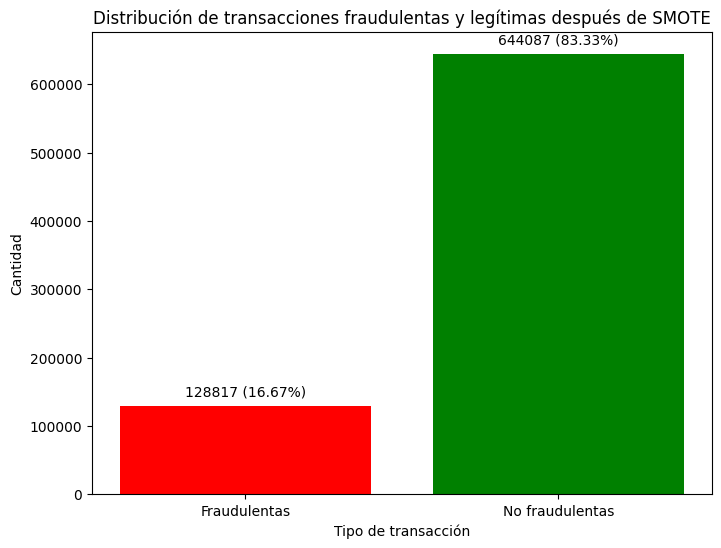

In [82]:
# Calcular la cantidad de transacciones fraudulentas y legítimas después de SMOTE
fraudulent_transactions_resampled = (y_train_resampled == 1).sum()
non_fraudulent_transactions_resampled = (y_train_resampled == 0).sum()
total_transactions_resampled = fraudulent_transactions_resampled + non_fraudulent_transactions_resampled

# Visualizar la distribución de transacciones fraudulentas y legítimas después de SMOTE
plt.figure(figsize=(8, 6))
plt.bar(['Fraudulentas', 'No fraudulentas'], [fraudulent_transactions_resampled, non_fraudulent_transactions_resampled], color=['red', 'green'])
plt.title('Distribución de transacciones fraudulentas y legítimas después de SMOTE')
plt.xlabel('Tipo de transacción')
plt.ylabel('Cantidad')

# Mostrar la proporción en el gráfico
for i, count in enumerate([fraudulent_transactions_resampled, non_fraudulent_transactions_resampled]):
    plt.text(i, count + total_transactions_resampled * 0.02, f"{count} ({count / total_transactions_resampled:.2%})", ha='center')

plt.show()

## Implementación de Modelos

Funcion para medir las metricas de los modelos

In [83]:
def model_metrics(model, dtest, y_test, model_name, optimal_threshold=0.5):

    # Predecir sobre el conjunto de prueba
    y_pred_proba = model.predict(dtest)

    # Calcular el umbral óptimo basado en la curva ROC
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
    optimal_idx_roc = np.argmax(tpr - fpr)
    optimal_threshold_roc = thresholds_roc[optimal_idx_roc]
    # print(f"Umbral óptimo basado en ROC: {optimal_threshold_roc}")

    # Calcular el umbral óptimo basado en la curva Precision-Recall
    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * recall * precision / (recall + precision + 1e-6)  # Para evitar la división por cero
    optimal_idx_pr = np.argmax(f1_scores)
    optimal_threshold_pr = thresholds_pr[optimal_idx_pr]
    # print(f"Umbral óptimo basado en Precision-Recall: {optimal_threshold_pr}")

    y_pred_proba = model.predict(dtest)
    y_pred = [1 if pred > optimal_threshold_roc else 0 for pred in y_pred_proba] # agarrar valor, area bajo la curva
    # test_loss, test_accuracy = model.evaluate(dtest, y_test, verbose=0)

    # Calcular y mostrar las métricas de evaluación
    print(f"Rendimiento del modelo {model_name}:")
    print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
    # print("Precision:", precision_score(y_test, y_pred))
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    # print("Accuracy: ", test_accuracy)
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))
    
    # Calcular la matriz de confusion
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Non-Fraud", "Fraud"], 
                yticklabels=["Non-Fraud", "Fraud"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    # Calcular la curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Calcular la curva de precisión-recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Graficar la curva de precisión-recall
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

ANN

In [84]:
# Definir la red neuronal
ann_model = tf.keras.Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train_resampled.shape[1],)),  
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),  
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])


# Compilar el modelo
ann_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Entrenar el modelo
history = ann_model.fit(X_train_resampled, y_train_resampled, 
                        epochs=5, 
                        batch_size=256, 
                        validation_data=(X_dev, y_dev), 
                        callbacks=[early_stopping, reduce_lr])

# guardar el modelo
ann_model.save('ANN Models/ann_model_2019.h5')

c:\Users\rjmom\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
3020/3020 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8634 - loss: 0.7969 - val_accuracy: 0.9894 - val_loss: 0.0855 - learning_rate: 0.0010
Epoch 2/5
3020/3020 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9561 - loss: 0.1757 - val_accuracy: 0.9908 - val_loss: 0.0809 - learning_rate: 0.0010
Epoch 3/5
3020/3020 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9574 - loss: 0.1684 - val_accuracy: 0.9915 - val_loss: 0.0779 - learning_rate: 0.0010
Epoch 4/5
3020/3020 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9585 - loss: 0.1634 - val_accuracy: 0.9888 - val_loss: 0.0779 - learning_rate: 0.0010
Epoch 5/5
3020/3020 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9583 - loss: 0.1634 - val_accuracy: 0.9904 - val_loss: 0.0753 - learning_rate: 0.0010


4336/4336 ━━━━━━━━━━━━━━━━━━━━ 4s 852us/step
4336/4336 ━━━━━━━━━━━━━━━━━━━━ 4s 882us/step
Rendimiento del modelo ANN:
ROC-AUC: 0.9821597019321394
Accuracy:  0.9598134478980451
Recall: 0.9357231149567367
F1-score: 0.21357032021441671
Confusion Matrix:
[[132396   5523]
 [    52    757]]


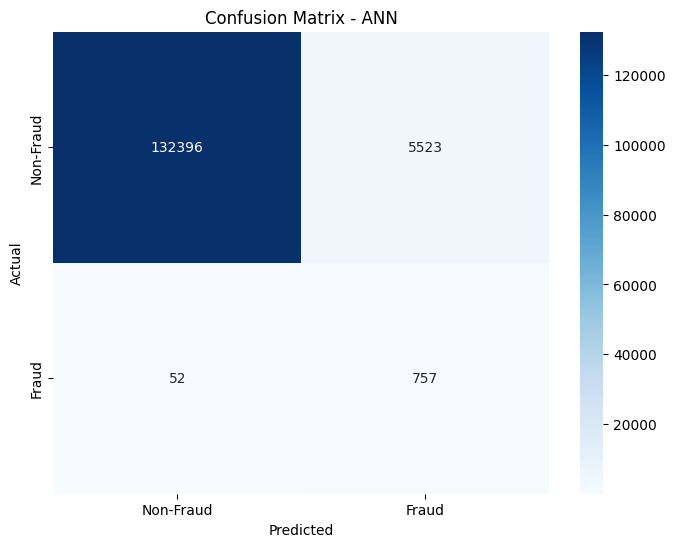

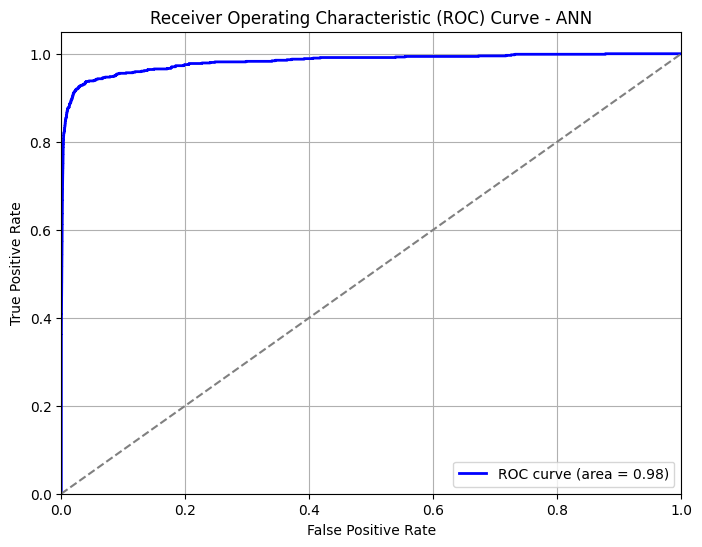

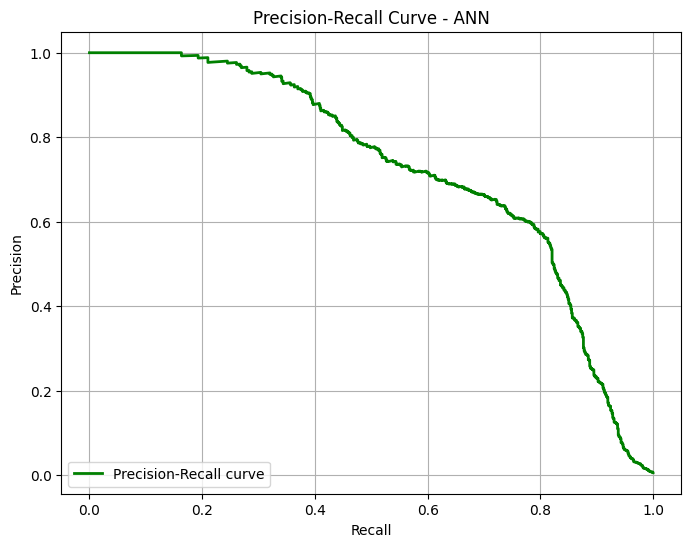

In [85]:
model_metrics(ann_model, X_test, y_test, "ANN")

LGBM

In [86]:
# Convertir los conjuntos de datos a DMatrix
train_data_batch = lgb.Dataset(X_train_resampled, label=y_train_resampled)

# Definir los parámetros del modelo
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbose': -1,
}

# Configurar el número de rondas
num_rounds_batch = 100
lgbm_model = lgb.train(params, train_data_batch, num_boost_round=num_rounds_batch)

# Guardar el modelo
lgbm_model.save_model('LGBM Models/lgb_model_2019.txt')

Rendimiento del modelo LightGBM:
ROC-AUC: 0.9977734015265638
Accuracy:  0.9828585433366012
Recall: 0.9740420271940667
F1-score: 0.398583712696004
Confusion Matrix:
[[135562   2357]
 [    21    788]]


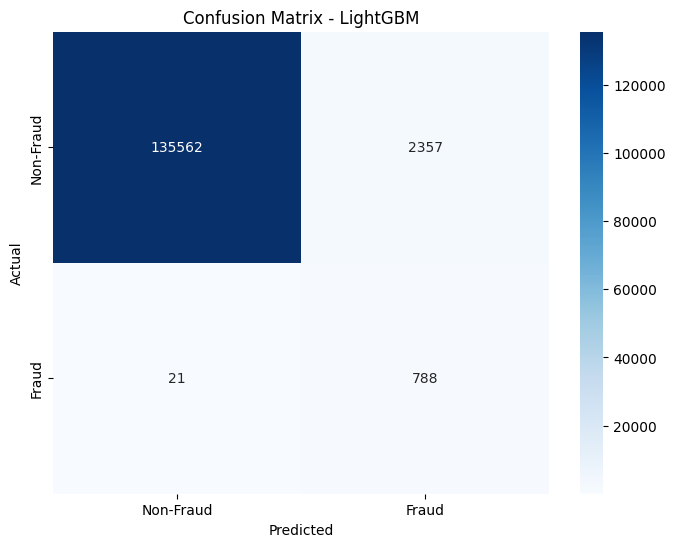

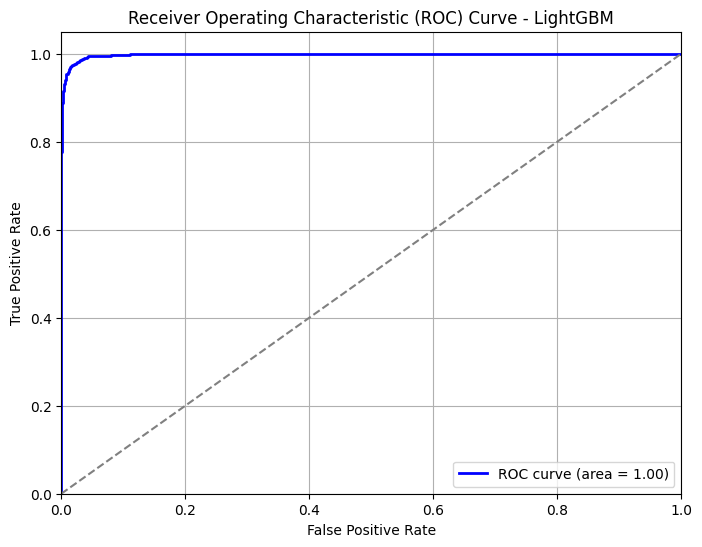

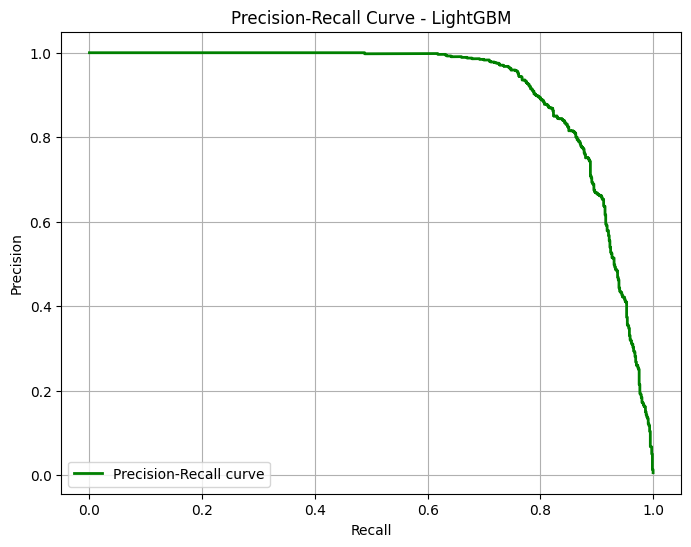

In [87]:
model_metrics(lgbm_model, X_test, y_test, "LightGBM")

XGBoost

In [88]:
# Convertir los datos al formato DMatrix de XGBoost
dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dtest = xgb.DMatrix(X_test)

# Definir los parámetros del modelo
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Entrenar el modelo XGBoost
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Guardar el modelo entrenado
xgb_model.save_model('XGB Models/xgb_model_2019.model')

c:\Users\rjmom\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:09:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Rendimiento del modelo XGBoost:
ROC-AUC: 0.9984410960622693
Accuracy:  0.9862825096591892
Recall: 0.9839307787391842
F1-score: 0.45550786838340485
Confusion Matrix:
[[136029   1890]
 [    13    796]]


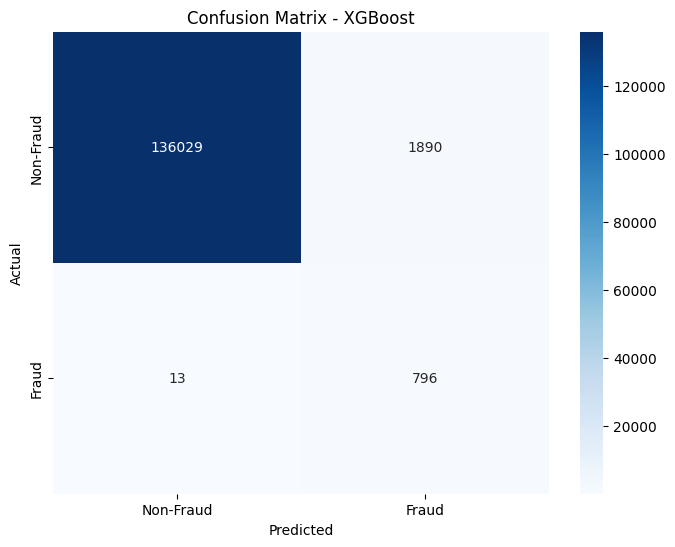

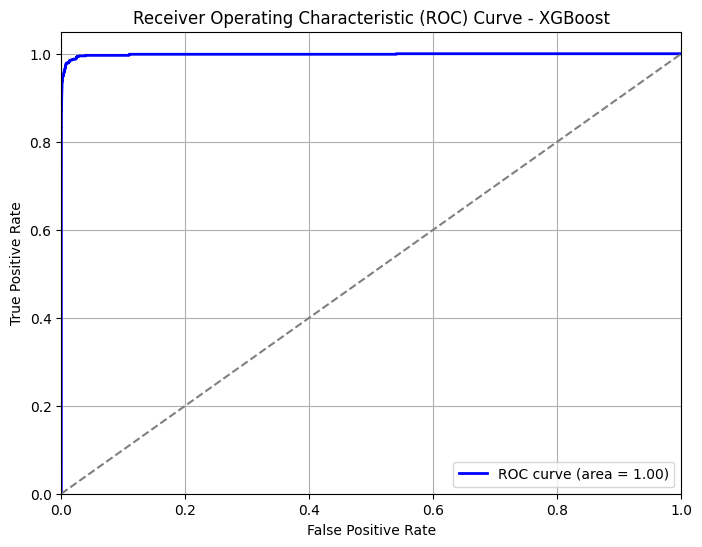

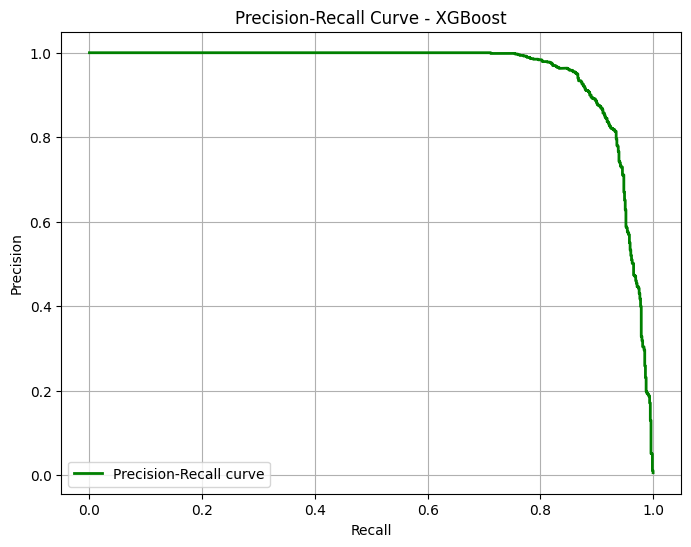

In [89]:
model_metrics(xgb_model, dtest, y_test, 'XGBoost')

### Batch 1 - 2020 enero a julio

Para el primer reentrenamiento incremental, se optó por utilizar los datos de enero a julio de 2020. Estos meses representan la primera mitad del año 2020 y se seleccionaron para permitir que el modelo se actualice con datos recientes, proporcionando así una actualización parcial del modelo. Al utilizar un batch más pequeño y reciente como el primero, se logra una adaptación progresiva del modelo a cambios más recientes en los datos.

In [90]:
# Seleccionar solo los datos del año 2020 de enero a julio
df_subset_2020 = df_processed[(df_processed['year'] == 2020) & (df_processed['month'] >= 1) & (df_processed['month'] <= 7)]

X_batch = df_subset_2020.drop(columns=['is_fraud'])
y_batch = df_subset_2020['is_fraud']

# Imputar valores faltantes en las características numéricas
imputer = SimpleImputer(strategy='mean')
X_batch_imputed = pd.DataFrame(imputer.fit_transform(X_batch), columns=X_batch.columns)

# Escalar las características numéricas para un mejor desempeño de SMOTE
scaler = StandardScaler()
X_batch_scaled = scaler.fit_transform(X_batch_imputed)

In [91]:
# Dividir los datos en Train, Dev y Test
X_train_dev_batch, X_test_batch, y_train_dev_batch, y_test_batch = train_test_split(X_batch_scaled, y_batch, test_size=0.15, random_state=42)

# Dividir los datos de Train y Dev
X_train_batch, X_dev_batch, y_train_batch, y_dev_batch = train_test_split(X_train_dev_batch, y_train_dev_batch, test_size=0.176, random_state=42)

# Calcular la cantidad de transacciones legítimas y fraudulentas en el conjunto de entrenamiento
non_fraud_count_batch = len(y_train_batch[y_train_batch == 0])
fraud_count_batch = non_fraud_count_batch // 5

# Definir la estrategia de muestreo para SMOTE
sampling_strategy_batch = {0: non_fraud_count_batch, 1: fraud_count_batch}
print("Estrategia de muestreo para SMOTE:", sampling_strategy_batch)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(sampling_strategy=sampling_strategy_batch, random_state=42)
X_train_resampled_batch, y_train_resampled_batch = smote.fit_resample(X_train_batch, y_train_batch)

# Verificar la forma de los datos después de aplicar SMOTE
print("Forma de X_train_resampled después de SMOTE:", X_train_resampled_batch.shape)
print("Forma de y_train_resampled después de SMOTE:", y_train_resampled_batch.shape)

Estrategia de muestreo para SMOTE: {0: 339678, 1: 67935}
Forma de X_train_resampled después de SMOTE: (407613, 20)
Forma de y_train_resampled después de SMOTE: (407613,)


ANN

In [92]:
# Cargar el modelo de red neuronal
ann_model_incremental = tf.keras.models.load_model('ANN Models/ann_model_2019.h5')

# Volver a compilar el modelo
ann_model_incremental.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con los nuevos datos
history_batch = ann_model_incremental.fit(X_train_resampled_batch, y_train_resampled_batch, epochs=5, batch_size=256, validation_data=(X_dev_batch, y_dev_batch))

# Guardar el modelo
ann_model_incremental.save('ANN Models/ann_model_2020.h5')

Epoch 1/5
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9631 - loss: 0.1477 - val_accuracy: 0.9900 - val_loss: 0.0688
Epoch 2/5
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9633 - loss: 0.1461 - val_accuracy: 0.9916 - val_loss: 0.0640
Epoch 3/5
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9641 - loss: 0.1440 - val_accuracy: 0.9912 - val_loss: 0.0650
Epoch 4/5
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9632 - loss: 0.1442 - val_accuracy: 0.9909 - val_loss: 0.0664
Epoch 5/5
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9631 - loss: 0.1441 - val_accuracy: 0.9924 - val_loss: 0.0652


2287/2287 ━━━━━━━━━━━━━━━━━━━━ 2s 901us/step
2287/2287 ━━━━━━━━━━━━━━━━━━━━ 2s 844us/step
Rendimiento del modelo ANN (2020):
ROC-AUC: 0.9827861496903789
Accuracy:  0.9667714598141061
Recall: 0.9182692307692307
F1-score: 0.23912363067292644
Confusion Matrix:
[[70347  2397]
 [   34   382]]


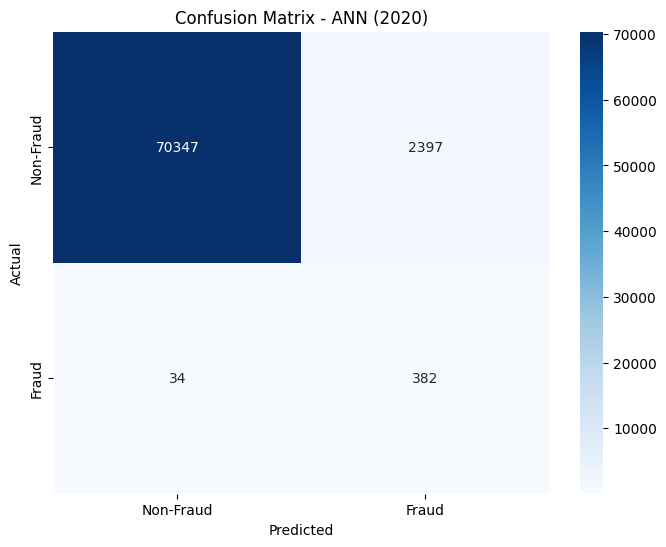

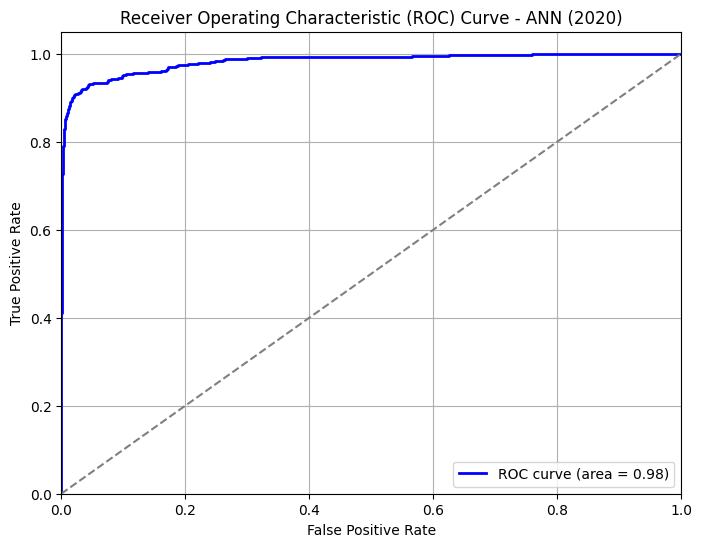

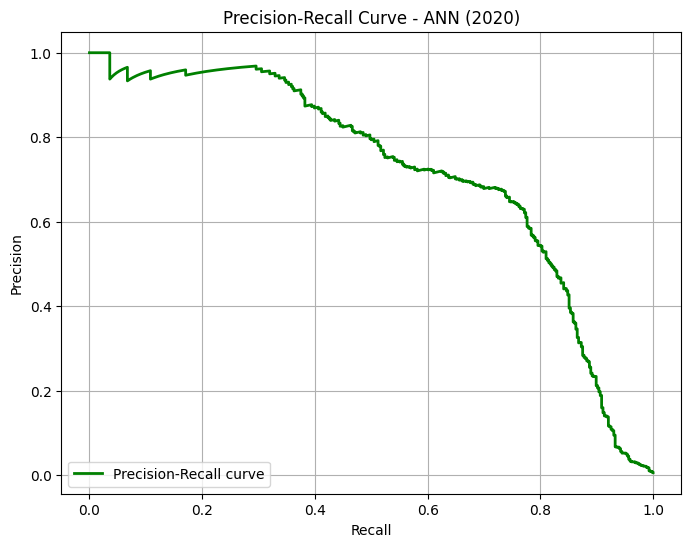

In [93]:
model_metrics(ann_model_incremental, X_test_batch, y_test_batch, "ANN (2020)")

LGBM

In [94]:
# Cargar el modelo LightGBM entrenado en 2019
lgbm_model_incremental = lgb.Booster(model_file='LGBM Models/lgb_model_2019.txt')

# Extraer los parámetros del modelo
params = lgbm_model_incremental.params

# Quitamos el número de rondas y la parada temprana del modelo
params.pop('early_stopping_round', None)

# Convertir los datos al formato DMatrix de LightGBM
train_data_batch = lgb.Dataset(X_train_resampled_batch, label=y_train_resampled_batch)

# Continuar entrenando el modelo con los nuevos datos (usamos el parametro init_model)
num_rounds_batch = 100
lgbm_model_incremental = lgb.train(params, train_data_batch, num_boost_round=num_rounds_batch, init_model=lgbm_model_incremental)

# Guardar el modelo actualizado
lgbm_model_incremental.save_model('LGBM Models/lgb_model_2020.txt')

c:\Users\rjmom\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Rendimiento del modelo LightGBM:
ROC-AUC: 0.9239895210523373
Accuracy:  0.9168300559367972
Recall: 0.8677379480840544
F1-score: 0.10848400556328233
Confusion Matrix:
[[126488  11431]
 [   107    702]]


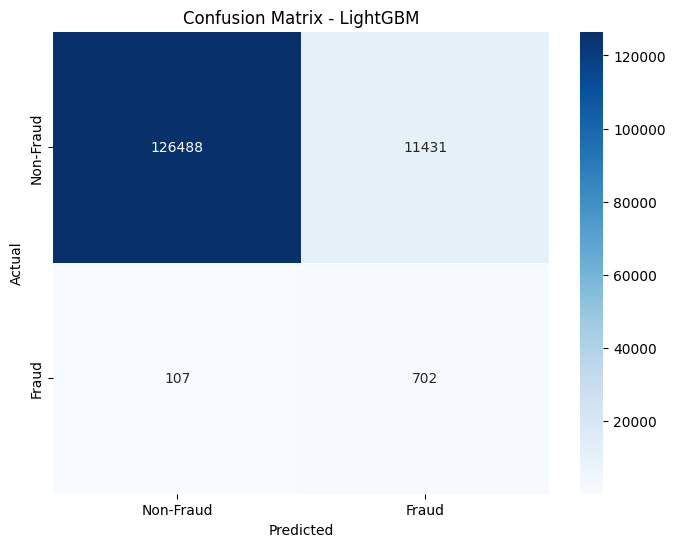

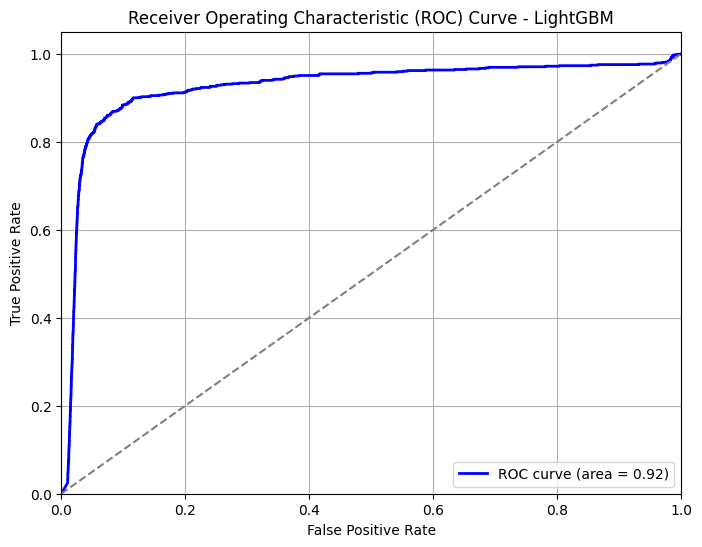

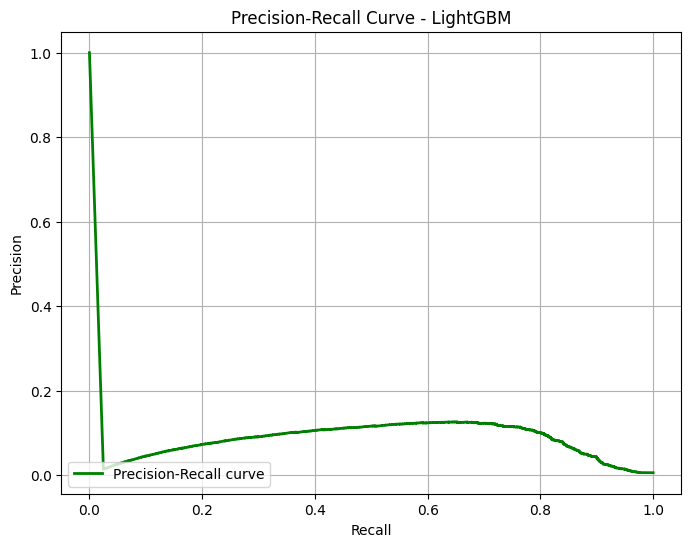

In [95]:
model_metrics(lgbm_model_incremental, X_test, y_test, "LightGBM")

XGBoost

In [96]:
# Cargar el modelo entrenado
xgb_model_incremental = xgb.Booster()
xgb_model_incremental.load_model('XGB Models/xgb_model_2019.model')

# Convertir los datos del batch al formato DMatrix de XGBoost
dtrain_batch = xgb.DMatrix(X_train_resampled_batch, label=y_train_resampled_batch)
dtest_batch = xgb.DMatrix(X_test_batch)

# Entrenar el modelo XGBoost con el nuevo batch de datos
num_rounds_batch = 100 
xgb_model_incremental.update(dtrain_batch, num_rounds_batch)

# Guardar el modelo actualizado
xgb_model_incremental.save_model('XGB Models/xgb_model_2020.model')

c:\Users\rjmom\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:10:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Rendimiento del modelo XGBoost:
ROC-AUC: 0.9354058707723185
Accuracy:  0.9617960634226354
Recall: 0.8221153846153846
F1-score: 0.19660822075308995
Confusion Matrix:
[[70023  2721]
 [   74   342]]


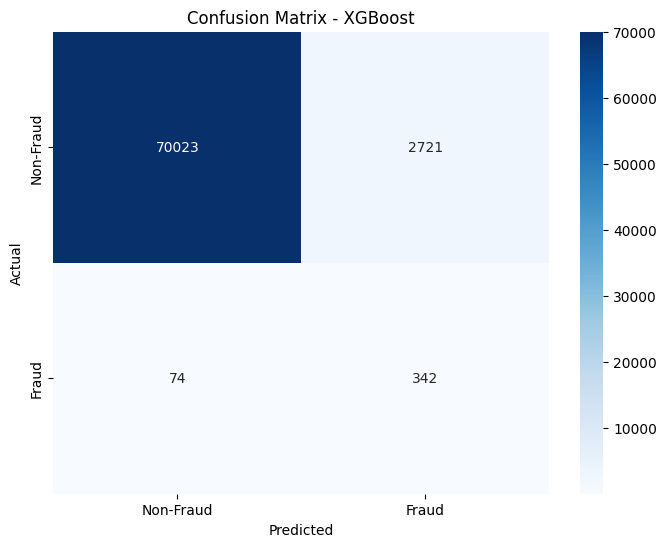

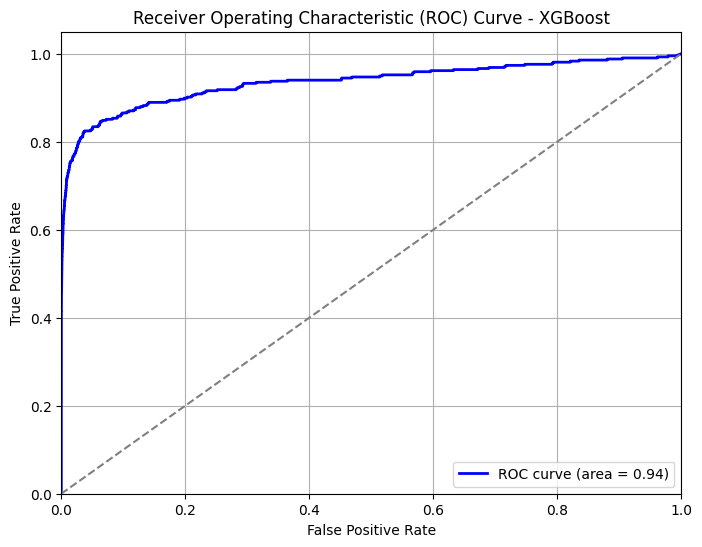

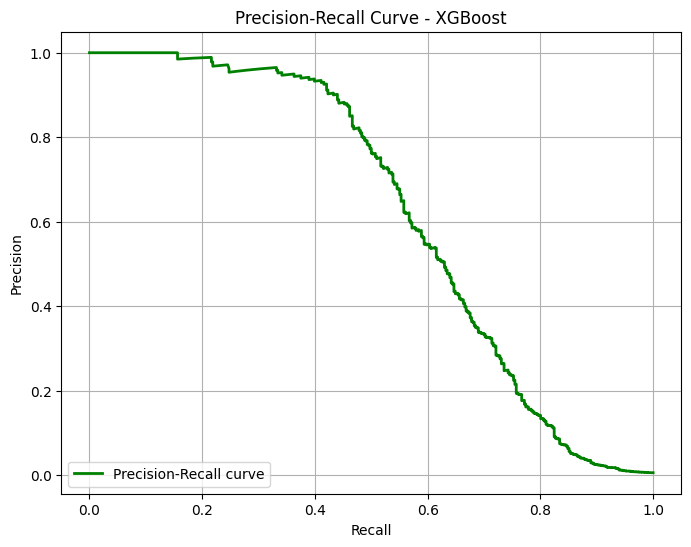

In [97]:
model_metrics(xgb_model_incremental, dtest_batch, y_test_batch, 'XGBoost')

### Batch 2 - 2020 agosto a diciembre

Para el segundo reentrenamiento incremental, se eligió utilizar los datos restantes de 2020, es decir, de agosto a diciembre. Estos meses completan el conjunto de datos del año 2020 y permiten al modelo adaptarse completamente a los datos más recientes disponibles. Al incluir el resto del año 2020 en este segundo reentrenamiento, se proporciona al modelo la oportunidad de capturar cualquier cambio estacional o tendencias adicionales que puedan haber ocurrido durante ese período.

In [98]:
# Seleccionar solo los datos del año 2020 de agosto a diciembre
df_subset_2020_batch2 = df_processed[(df_processed['year'] == 2020) & (df_processed['month'] >= 8) & (df_processed['month'] <= 12)]

X_batch2 = df_subset_2020_batch2.drop(columns=['is_fraud'])
y_batch2 = df_subset_2020_batch2['is_fraud']

# Imputar valores faltantes en las características numéricas
imputer = SimpleImputer(strategy='mean')
X_batch2_imputed = pd.DataFrame(imputer.fit_transform(X_batch2), columns=X_batch2.columns)

# Escalar las características numéricas para un mejor desempeño de SMOTE
scaler = StandardScaler()
X_batch2_scaled = scaler.fit_transform(X_batch2_imputed)

In [99]:
# Dividir los datos en Train, Dev y Test
X_train_dev_batch2, X_test_batch2, y_train_dev_batch2, y_test_batch2 = train_test_split(X_batch2_scaled, y_batch2, test_size=0.15, random_state=42)

# Dividir los datos de Train y Dev
X_train_batch2, X_dev_batch2, y_train_batch2, y_dev_batch2 = train_test_split(X_train_dev_batch2, y_train_dev_batch2, test_size=0.176, random_state=42)

# Calcular la cantidad de transacciones legítimas y fraudulentas en el conjunto de entrenamiento
non_fraud_count_batch2 = len(y_train_batch2[y_train_batch2 == 0])
fraud_count_batch2 = non_fraud_count_batch2 // 5

# Definir la estrategia de muestreo para SMOTE
sampling_strategy_batch2 = {0: non_fraud_count_batch2, 1: fraud_count_batch2}
print("Estrategia de muestreo para SMOTE:", sampling_strategy_batch2)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(sampling_strategy=sampling_strategy_batch2, random_state=42)
X_train_resampled_batch2, y_train_resampled_batch2 = smote.fit_resample(X_train_batch2, y_train_batch2)

# Verificar la forma de los datos después de aplicar SMOTE
print("Forma de X_train_resampled_batch2 después de SMOTE:", X_train_resampled_batch2.shape)
print("Forma de y_train_resampled_batch2 después de SMOTE:", y_train_resampled_batch2.shape)

Estrategia de muestreo para SMOTE: {0: 306861, 1: 61372}
Forma de X_train_resampled_batch2 después de SMOTE: (368233, 20)
Forma de y_train_resampled_batch2 después de SMOTE: (368233,)


ANN

In [100]:
# Cargar el modelo de red neuronal
ann_model_incremental2 = tf.keras.models.load_model('ANN Models/ann_model_2020.h5')

# Volver a compilar el modelo
ann_model_incremental2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con los nuevos datos
history_batch2 = ann_model_incremental2.fit(X_train_resampled_batch2, y_train_resampled_batch2, epochs=5, batch_size=256, validation_data=(X_dev_batch2, y_dev_batch2))

# Guardar el modelo
ann_model_incremental2.save('ANN Models/ann_model_2020_2.h5')

Epoch 1/5
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9593 - loss: 0.1521 - val_accuracy: 0.9920 - val_loss: 0.0633
Epoch 2/5
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9631 - loss: 0.1398 - val_accuracy: 0.9929 - val_loss: 0.0649
Epoch 3/5
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9622 - loss: 0.1394 - val_accuracy: 0.9918 - val_loss: 0.0601
Epoch 4/5
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9636 - loss: 0.1374 - val_accuracy: 0.9912 - val_loss: 0.0605
Epoch 5/5
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9639 - loss: 0.1350 - val_accuracy: 0.9923 - val_loss: 0.0567


2062/2062 ━━━━━━━━━━━━━━━━━━━━ 2s 967us/step
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 2s 872us/step
Rendimiento del modelo ANN (2020):
ROC-AUC: 0.9840117318394068
Accuracy:  0.9557236403322622
Recall: 0.918918918918919
F1-score: 0.14012363850456286
Confusion Matrix:
[[62813  2900]
 [   21   238]]


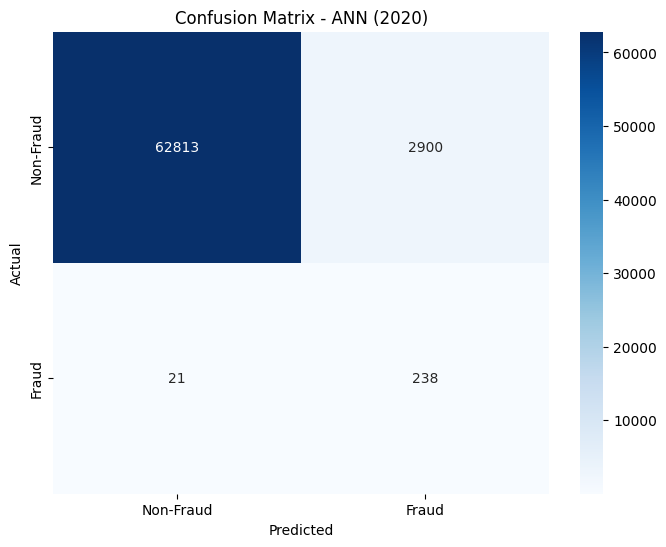

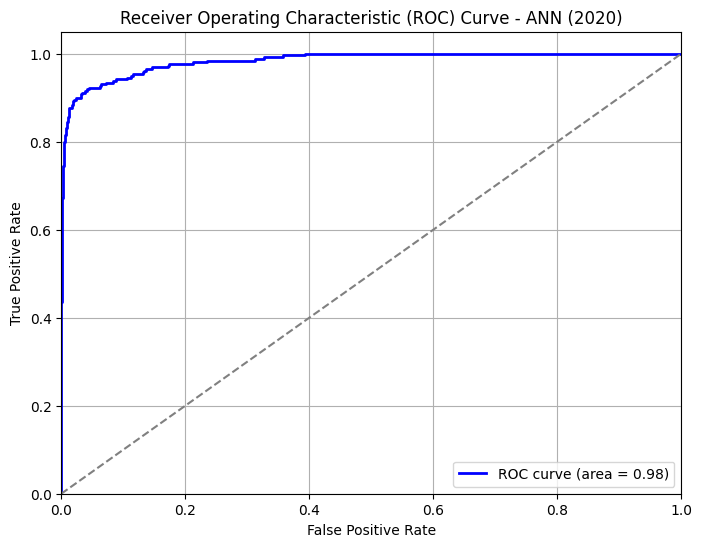

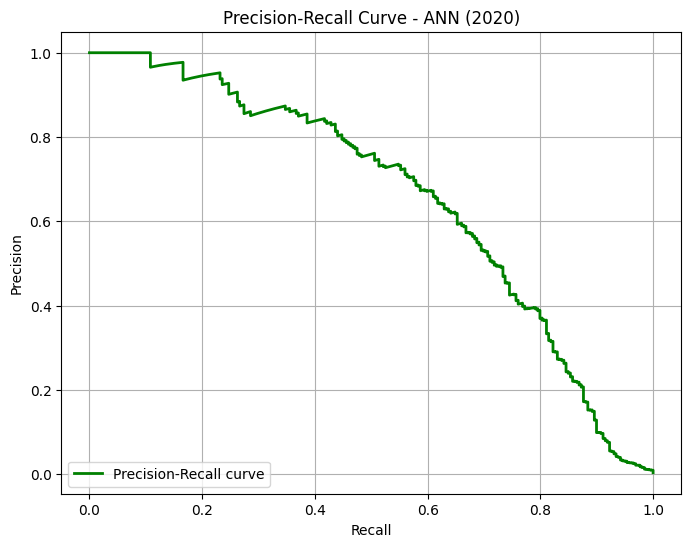

In [101]:
model_metrics(ann_model_incremental2, X_test_batch2, y_test_batch2, "ANN (2020)")

LGBM

In [102]:
# Cargar el modelo LightGBM entrenado en 2019
lgbm_model_incremental2 = lgb.Booster(model_file='LGBM Models/lgb_model_2019.txt')

# Extraer los parámetros del modelo
params = lgbm_model_incremental2.params

# Quitamos el número de rondas y la parada temprana del modelo
params.pop('early_stopping_round', None)

# Convertir los datos al formato DMatrix de LightGBM
train_data_batch2 = lgb.Dataset(X_train_resampled_batch2, label=y_train_resampled_batch2)

# Continuar entrenando el modelo con los nuevos datos
num_rounds_batch2 = 100
lgbm_model_incremental2 = lgb.train(params, train_data_batch2, num_boost_round=num_rounds_batch2, init_model=lgbm_model_incremental2)

# Guardar el modelo actualizado
lgbm_model_incremental2.save_model('LGBM Models/lgb_model_2020_2.txt')

c:\Users\rjmom\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


2062/2062 ━━━━━━━━━━━━━━━━━━━━ 2s 953us/step
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 2s 843us/step
Rendimiento del modelo LGBM (2020):
ROC-AUC: 0.9840117318394068
Accuracy:  0.9557236403322622
Recall: 0.918918918918919
F1-score: 0.14012363850456286
Confusion Matrix:
[[62813  2900]
 [   21   238]]


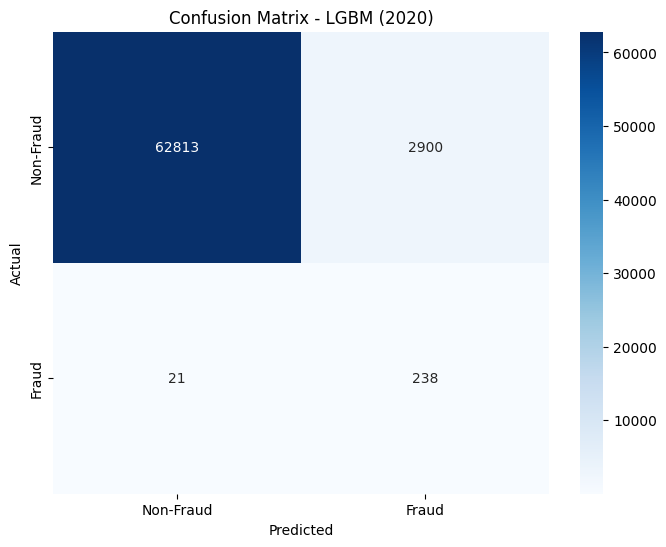

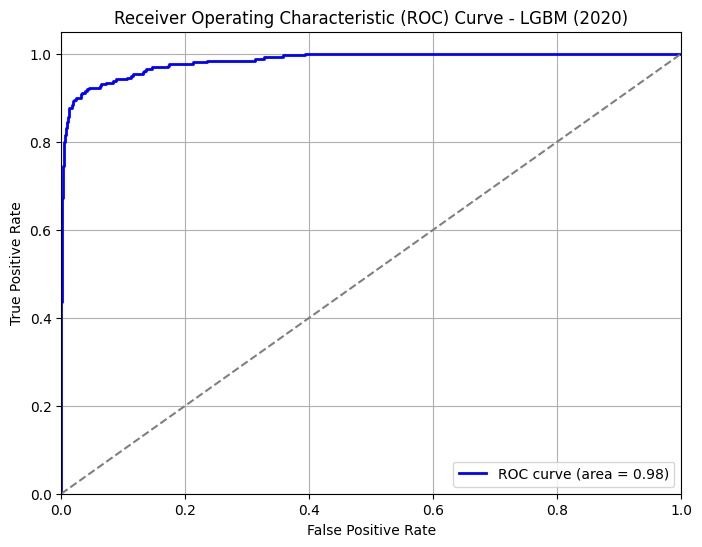

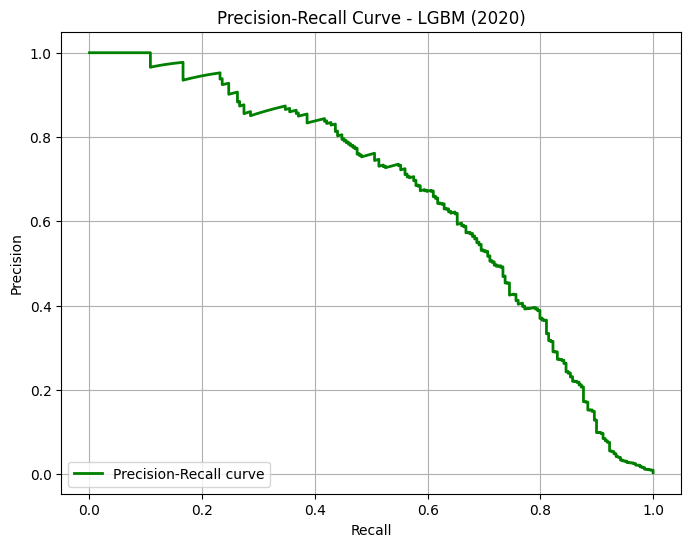

In [103]:
model_metrics(ann_model_incremental2, X_test_batch2, y_test_batch2, "LGBM (2020)")

XGBoost

In [104]:
# Cargar el modelo entrenado
xgb_model_incremental2 = xgb.Booster()
xgb_model_incremental2.load_model('XGB Models/xgb_model_2020.model')

# Convertir los datos del batch al formato DMatrix de XGBoost
dtrain_batch2 = xgb.DMatrix(X_train_resampled_batch2, label=y_train_resampled_batch2)
dtest_batch2 = xgb.DMatrix(X_test_batch2)

# Entrenar el modelo XGBoost con el nuevo batch de datos
num_rounds_batch2 = 100 
xgb_model_incremental2.update(dtrain_batch2, num_rounds_batch2)

# Guardar el modelo actualizado
xgb_model_incremental2.save_model('XGB Models/xgb_model_2020_2.model')

c:\Users\rjmom\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:11:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Rendimiento del modelo XGBoost:
ROC-AUC: 0.9431087576507813
Accuracy:  0.8483599102649609
Recall: 0.8918918918918919
F1-score: 0.044142939040703225
Confusion Matrix:
[[55737  9976]
 [   28   231]]


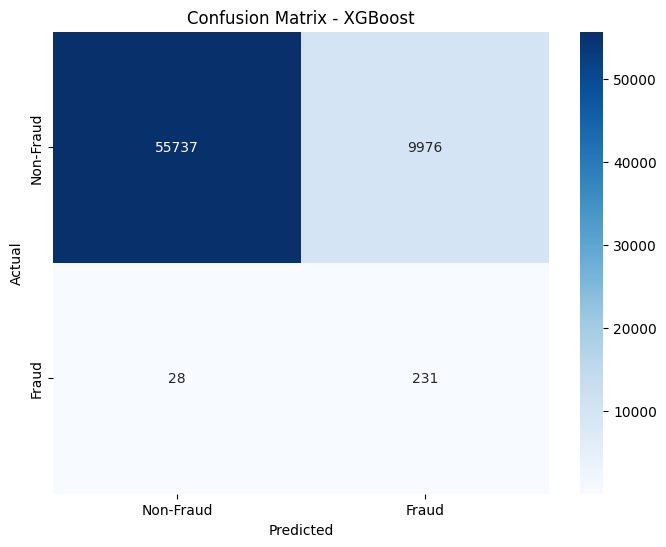

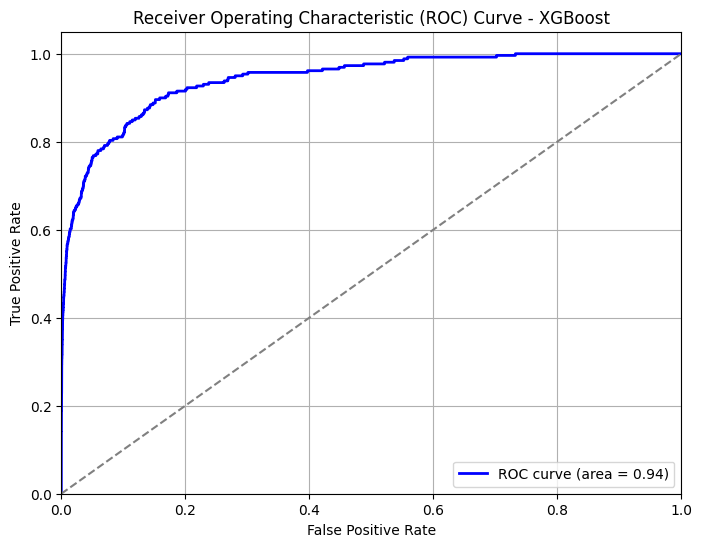

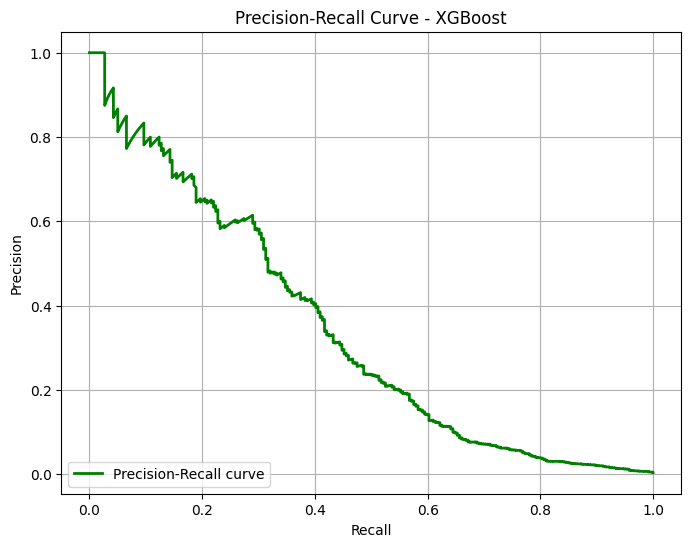

In [105]:
model_metrics(xgb_model_incremental2, dtest_batch2, y_test_batch2, 'XGBoost')

## Comparando Resultados

In [106]:
def evaluate_model(model, X_test, y_test, model_name, optimal_threshold=0.5):
    # Predecir sobre el conjunto de prueba
    y_pred_proba = model.predict(X_test)

    # Calcular el umbral óptimo basado en la curva ROC
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
    optimal_idx_roc = np.argmax(tpr - fpr)
    optimal_threshold_roc = thresholds_roc[optimal_idx_roc]
    # print(f"Umbral óptimo basado en ROC: {optimal_threshold_roc}")

    # Calcular el umbral óptimo basado en la curva Precision-Recall
    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * recall * precision / (recall + precision + 1e-6)  # Para evitar la división por cero
    optimal_idx_pr = np.argmax(f1_scores)
    optimal_threshold_pr = thresholds_pr[optimal_idx_pr]
    # print(f"Umbral óptimo basado en Precision-Recall: {optimal_threshold_pr}")

    # Aplicar el umbral óptimo basado en Precision-Recall (o puedes usar el de ROC)
    y_pred = [1 if pred > optimal_threshold_roc else 0 for pred in y_pred_proba]

    # Calcular y mostrar las métricas de evaluación
    print(f"Rendimiento del modelo {model_name} con umbral óptimo:")
    print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    # print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))
    
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("")

ANN

In [107]:
# Cargas los modelos entrenados de ANN
ann_model_2019 = tf.keras.models.load_model('ANN Models/ann_model_2019.h5')
ann_model_2020 = tf.keras.models.load_model('ANN Models/ann_model_2020.h5')
ann_model_2020_2 = tf.keras.models.load_model('ANN Models/ann_model_2020_2.h5')

In [108]:
# Evaluar los modelos de ANN
evaluate_model(ann_model_2019, X_test, y_test, "ANN 2019")
evaluate_model(ann_model_2020, X_test_batch, y_test_batch, "ANN 2020_1")
evaluate_model(ann_model_2020_2, X_test_batch2, y_test_batch2, "ANN 2020_2")

4336/4336 ━━━━━━━━━━━━━━━━━━━━ 4s 936us/step
Rendimiento del modelo ANN (2019) con umbral óptimo:
ROC-AUC: 0.9821597019321394
Accuracy: 0.9598134478980451
Recall: 0.9357231149567367
F1-score: 0.21357032021441671
Confusion Matrix:
[[132396   5523]
 [    52    757]]

2287/2287 ━━━━━━━━━━━━━━━━━━━━ 2s 907us/step
Rendimiento del modelo ANN (2020) con umbral óptimo:
ROC-AUC: 0.9827861496903789
Accuracy: 0.9667714598141061
Recall: 0.9182692307692307
F1-score: 0.23912363067292644
Confusion Matrix:
[[70347  2397]
 [   34   382]]

2062/2062 ━━━━━━━━━━━━━━━━━━━━ 2s 918us/step
Rendimiento del modelo ANN (2020) con umbral óptimo:
ROC-AUC: 0.9840117318394068
Accuracy: 0.9557236403322622
Recall: 0.918918918918919
F1-score: 0.14012363850456286
Confusion Matrix:
[[62813  2900]
 [   21   238]]



LGBM

In [109]:
# Cargar los modelos entrenados de LightGBM
lgb_model_2019 = lgb.Booster(model_file='LGBM Models/lgb_model_2019.txt')
lgb_model_2020 = lgb.Booster(model_file='LGBM Models/lgb_model_2020.txt')
lgb_model_2020_2 = lgb.Booster(model_file='LGBM Models/lgb_model_2020_2.txt')

In [110]:
# Evaluar los modelos de LightGBM
evaluate_model(lgb_model_2019, X_test, y_test, "LightGBM 2019")
evaluate_model(lgb_model_2020, X_test_batch, y_test_batch, "LightGBM 2020_1")
evaluate_model(lgb_model_2020_2, X_test_batch2, y_test_batch2, "LightGBM 2020_2")

Rendimiento del modelo LightGBM (2019) con umbral óptimo:
ROC-AUC: 0.9977734015265638
Accuracy: 0.9828585433366012
Recall: 0.9740420271940667
F1-score: 0.398583712696004
Confusion Matrix:
[[135562   2357]
 [    21    788]]

Rendimiento del modelo LightGBM (2020) con umbral óptimo:
ROC-AUC: 0.9748295392059827
Accuracy: 0.9862629852378348
Recall: 0.9254807692307693
F1-score: 0.43380281690140843
Confusion Matrix:
[[71770   974]
 [   31   385]]

Rendimiento del modelo LightGBM (2020) con umbral óptimo:
ROC-AUC: 0.9896133102956715
Accuracy: 0.9817195173710059
Recall: 0.9536679536679536
F1-score: 0.29058823529411765
Confusion Matrix:
[[64519  1194]
 [   12   247]]



XGBoost

In [111]:
# Cargar los modelos entrenados de XGBoost
xgb_model_2019 = xgb.Booster({'nthread': 4})  
xgb_model_2019.load_model('XGB Models/xgb_model_2019.model')

xgb_model_2020_1 = xgb.Booster({'nthread': 4})  
xgb_model_2020_1.load_model('XGB Models/xgb_model_2020.model')

xgb_model_2020_2 = xgb.Booster({'nthread': 4})  
xgb_model_2020_2.load_model('XGB Models/xgb_model_2020_2.model')

In [113]:
# Evaluar los modelos XGBoost
evaluate_model(xgb_model_2019, dtest, y_test, 'XGBoost 2019')
evaluate_model(xgb_model_2020_1, dtest_batch, y_test_batch, "XGBoost 2020_1")
evaluate_model(xgb_model_2020_2, dtest_batch2, y_test_batch2, "XGBoost 2020_2")

Rendimiento del modelo XGBoost con umbral óptimo:
ROC-AUC: 0.9984410960622693
Accuracy: 0.9862825096591892
Recall: 0.9839307787391842
F1-score: 0.45550786838340485
Confusion Matrix:
[[136029   1890]
 [    13    796]]

Rendimiento del modelo XGBoost 2020_1 con umbral óptimo:
ROC-AUC: 0.9354058707723185
Accuracy: 0.9617960634226354
Recall: 0.8221153846153846
F1-score: 0.19660822075308995
Confusion Matrix:
[[70023  2721]
 [   74   342]]

Rendimiento del modelo XGBoost 2020_2 con umbral óptimo:
ROC-AUC: 0.9431087576507813
Accuracy: 0.8483599102649609
Recall: 0.8918918918918919
F1-score: 0.044142939040703225
Confusion Matrix:
[[55737  9976]
 [   28   231]]

